The following cell needs to be run only once to install the packages that may not be available

In [1]:
%%capture 
!pip install nltk
!pip install gensim
!pip install itertools
!pip install spacy
!pip install langdetect
!pip install pprint
!pip install pyLDAvis

In [2]:
!pip install scipy==1.12


    extract-msg (<=0.29.*)
                 ~~~~~~~^


In [3]:
import os
import re
import pandas as pd
import nltk
from nltk.tokenize import regexp_tokenize
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from collections import Counter
from nltk.stem import WordNetLemmatizer
from string import punctuation
from pprint import pprint
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.stem import PorterStemmer
from nltk.util import ngrams

import pyLDAvis

from collections import defaultdict
import itertools
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline




/Users/yektaamirkhalili/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/yektaamirkhalili/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [4]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

/Users/yektaamirkhalili/opt/anaconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
!pip install scipy==1.12.0 --quiet


    extract-msg (<=0.29.*)
                 ~~~~~~~^


In [6]:
__requires__= 'scipy==1.12.0'

import scipy
print(scipy.__version__)

1.12.0


In [7]:
import numpy as np
from numpy import triu
import scipy
from scipy.linalg.special_matrices import triu

import gensim
from gensim.models import Phrases
from gensim.models.phrases import Phraser


from gensim.corpora.dictionary import Dictionary
from gensim.corpora import MmCorpus

from gensim.models.tfidfmodel import TfidfModel
from langdetect import detect, DetectorFactory
from gensim.models import CoherenceModel


import pyLDAvis.gensim_models as gensimvis
import pyLDAvis.gensim
import pyLDAvis.gensim_models

In [8]:
# only run once 
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('omw-1.4')  # Optional for better language support
nltk.download('averaged_perceptron_tagger')  # For POS tagging
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yektaamirkhalili/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/yektaamirkhalili/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/yektaamirkhalili/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/yektaamirkhalili/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/yektaamirkhalili/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/yektaamirkhalili/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perc

True

# CLEANING AND PRE-PROCESSING DATA 

The following procedures are implemented for Data Cleaning: 

1. Only keep English reviews (remove non-English) --- Task: check before and after number of rows (to see how many got deleted)
2. Turn everything into lower case 
3. Remove stopwords + additional stopwords such as "from" "subject" "reply" "app" "bank" "banking" + names of the banks "CIBC", "TD", "BMO", "RBC", "SCOTIA"
4. Remove punctuation 
5. Lemming/Stemming  

Throughtout this process, several **Variations** of the data are kept: 
1. `reviews` is a list of the original data frame's reviews column where each user review is an entry in the list
2. `reviews_corpus` is a block of text where all reviews are joined together, and everything is lower cased  
3. `tokenized_doc_to_sentences` is the sentence tokenized version of `reviews_corpus`, a list of strings 
4. `tokenized_doc_to_words` is the word tokenized version of `tokenized_doc_to_sentences`, a list of lists where each outer list a review, then the inner lists each correspond to the sentences within the review 

The data cleaning is performed on all variations of the data. Therefore, each 4 types of data that are kept have clean and raw versions. Both types are saved to disk for easier upload later. 

# IMPORTANT FUNCTIONS 

Below are descriptions of functions. At various points, we have employed the help of ChatGPT4 (chat.openai.com). Please look out for the comment indicating start and end of code provided or fixed by AI. 

1. `is_english` detects non-English and English texts. We use this function for data cleaning, as several of the reviews are in languages other than English. 
2. `remove_punc` removes punctuation specifically declared as a regular expression in `punctuation_to_remove` 
3. `generate_dictionary` creates a gensim dictionary and corpus, and saves the dictionary to a matrix model format for easier retrival 
4. `print_top_10_words` prints the top 10 words in a corpus using TF-IDF (weighted)
5. `build_lda_model` builds our topic modeling model based on LDA, allowing for several models with different parameters to be trained for comparison to pick the best model parameters (parameter tuning)
6. `train_models` trains the LDA models and returns a list with all the models 
7. `calculate_preplexity` calculates model perplexity 
8. `calculate_coherence` calculates model coherence 
9. `print_topics` prints the topic modeling results with word weights 
10. `remove_stopwords_from_sentence` removes stopwords from sentences while keeping the sentence structure   
11. `build_model_comparison_table` trains several models, and saves the results of perplexity and coherence in one dataframe for easy comparison 
12. `find_best_model` loops through the dataframe of all models trained and finds minimum perplexity and maximum coherence 
13. `pick_best_model` returns the model parameters that give the best combination perplexity and coherence scores 


In [9]:
# ---------------------- START OF CHATGPT CODE
# PROMPT was: finish this function: def save_file(name, extension, content):
def save_file(name, extension, content):
    """
    Save a file with the specified name, extension, and content.

    Args:
    name (str): The name of the file (without extension).
    extension (str): The file extension (e.g., 'txt', 'csv').
    content (str): The content to be saved in the file.

    Returns:
    None
    """
    # Combine name and extension to form the full file name
    filename = f"{name}.{extension}"

    # Check if the file already exists
    if os.path.exists(filename):
        print(f"The file {filename} already exists. Overwriting...")
    
    # Open the file and write the content
    try:
        with open(filename, 'w') as file:
            file.write(content)
        print(f"File {filename} saved successfully.")
    except Exception as e:
        print(f"Error while saving file: {e}")
# ---------------------- END OF CHATGPT CODE 



## DATASET 

In [10]:
df_neg = pd.read_csv("negative_data_ios.csv")
df_pos = pd.read_csv("positive_data_ios.csv")
df_net = pd.read_csv("neutral_data_ios.csv")

In [11]:
df_neg = df_neg.copy()
df_pos = df_pos.copy()
df_net = df_net.copy()

In [12]:
df_neg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5475 entries, 0 to 5474
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   rating        5475 non-null   int64 
 1   title         5475 non-null   object
 2   review        5475 non-null   object
 3   Bank          5475 non-null   object
 4   man_label     5475 non-null   object
 5   blob_labels   5475 non-null   object
 6   vader_labels  5475 non-null   object
 7   LSTM_label    5475 non-null   object
dtypes: int64(1), object(7)
memory usage: 342.3+ KB


In [13]:
df_pos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3413 entries, 0 to 3412
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   rating        3413 non-null   int64 
 1   title         3412 non-null   object
 2   review        3413 non-null   object
 3   Bank          3413 non-null   object
 4   man_label     3413 non-null   object
 5   blob_labels   3413 non-null   object
 6   vader_labels  3413 non-null   object
 7   LSTM_label    3413 non-null   object
dtypes: int64(1), object(7)
memory usage: 213.4+ KB


In [14]:
df_net.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   rating        1440 non-null   int64 
 1   title         1440 non-null   object
 2   review        1439 non-null   object
 3   Bank          1440 non-null   object
 4   man_label     1440 non-null   object
 5   blob_labels   1440 non-null   object
 6   vader_labels  1440 non-null   object
 7   LSTM_label    1440 non-null   object
dtypes: int64(1), object(7)
memory usage: 90.1+ KB


In [15]:
df_neg.head()

,rating,title,review,Bank,man_label,blob_labels,vader_labels,LSTM_label
0,1,Works terrible on my new phone,"new phone, practically every time open asks ve...",BMO,negative,neutral,positive,negative
1,1,Not working with iOS12.2,won’t work ios.. every time open turn white st...,BMO,negative,neutral,negative,negative
2,1,Always signs me out,"sign out, forgets card number enter card, pass...",BMO,negative,neutral,negative,negative
3,1,Insights,insight terrible integration. take logins feat...,BMO,negative,negative,negative,negative
4,3,Please fix it!,"working fine, updated it, won’t open. please f...",BMO,neutral,neutral,positive,negative


### DATA VERSIONS - BEFORE CLEANING 

In [16]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 'reply', 'banking', 'bank', 'app', 'apps', 'banks', 'cibc', 'rbc', 'td', 'scotia', 'bmo'])

In [25]:
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer


def remove_punc(text):

#     """Takes in some text, removes specific punctuations from them"""
#     punctuation_to_remove = r"[\[\]\(\)!?‘’'\'\"\.,;:]"
#     # punctuation_to_remove = r"[\[\]\(\)!?\"\.,;:]"
#     no_punc = re.sub(punctuation_to_remove, "", text)
#     no_punc_words = [word for word in text if word not in punctuation]
#     no_punc = ''.join(no_punc_words)
    
#     return no_punc
    punctuation_to_remove = r"[\[\]\(\)!?‘’'\".,;:]"
    no_punc = re.sub(punctuation_to_remove, "", text)
    return no_punc



def remove_stopwords_from_sentence(sentence):

    filtered_words = [word for word in sentence.split() if word.lower() not in stop_words]
    
    filtered_sentence = ' '.join(filtered_words)

    return filtered_sentence


def generate_data(df):
    """
    Automate all the tasks for cleaning data - make sure column name is correct! 
    """
    
#     reviews = list(df['review']) 
#     reviews_corpus = " ".join([str(review) for review in reviews])

#     tokenized_doc_to_sentences = sent_tokenize(reviews_corpus)

#     tokenized_doc_to_words = [word_tokenize(sent) for sent in tokenized_doc_to_sentences]
    
#     reviews_corpus_lc = list(df['review'])
#     reviews_corpus_lc = [review.lower() for review in reviews_corpus_lc]

#     tokenized_doc_to_sentences_lc_review_Sentenced = [sent_tokenize(review) for review in reviews_corpus_lc] 

#     tokenized_doc_to_sentences_lc = sent_tokenize(' '.join(reviews_corpus_lc))
#     tokenized_doc_to_words_lc = [word_tokenize(sent) for sent in tokenized_doc_to_sentences_lc]


#     reviews_corpus_stpw = list(df['review'].apply(remove_stopwords_from_sentence))
#     tokenized_doc_to_sentences_stpw = sent_tokenize(' '.join(reviews_corpus_stpw))
#     tokenized_doc_to_words_stpw = [word_tokenize(sent) for sent in tokenized_doc_to_sentences_stpw]

#     reviews_corpus_noPnc = [remove_punc(review) for review in reviews_corpus_stpw] 
#     tokenized_doc_to_sentences_noPnc = [remove_punc(sentence) for sentence in tokenized_doc_to_sentences_stpw]
#     tokenized_doc_to_words_noPnc = [word_tokenize(sent) for sent in tokenized_doc_to_sentences_noPnc]
    
    # SOURCE for code: https://www.analyticsvidhya.com/blog/2022/07/sentiment-analysis-using-python/

    token = RegexpTokenizer(r'[a-zA-Z0-9]+') # get rid of punctuation and non alphanumeric characters + tokenize to word 

    cv = CountVectorizer(stop_words = stop_words, ngram_range = (1,1), tokenizer = token.tokenize) #count word matrix 

    reviews_word_counts = cv.fit_transform(df['review'])

    df['review'] = df['review'].apply(lambda x: ' '.join(x.lower() for x in x.split()))
    
    df['review'] = df['review'].apply(lambda x: re.sub(r'\d+', '', x))  
    
    df['review'] = df['review'].apply(lambda x: ' '.join(x for x in x.split() if x not in stop_words))
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    df['review'] = df['review'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))
    
    return df



In [26]:
neg_df_clean = generate_data(df_neg)

In [27]:
neg_df_clean.head()

,rating,title,review,Bank,man_label,blob_labels,vader_labels,LSTM_label
0,1,Works terrible on my new phone,"new phone, practically every time open asks ve...",BMO,negative,neutral,positive,negative
1,1,Not working with iOS12.2,won’t work ios.. every time open turn white st...,BMO,negative,neutral,negative,negative
2,1,Always signs me out,"sign out, forgets card number enter card, pass...",BMO,negative,neutral,negative,negative
3,1,Insights,insight terrible integration. take logins feat...,BMO,negative,negative,negative,negative
4,3,Please fix it!,"working fine, updated it, won’t open. please f...",BMO,neutral,neutral,positive,negative


In [28]:
pos_df_clean = generate_data(df_pos)


/Users/yektaamirkhalili/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [29]:
df_net = df_net.dropna(axis = 0)
net_df_clean = generate_data(df_net)

### ANALYSIS FUNCTIONS 

In [30]:
def print_top_words(corpus_, dictionary_):
    total_word_count = defaultdict(int)
    word_weights = defaultdict(float)

    for word_id, word_count in itertools.chain.from_iterable(corpus_):
        total_word_count[word_id] += word_count
        
    sorted_tota_words_count = sorted(total_word_count.items(), key = lambda w: w[1], reverse = True)
    
    tfidf = TfidfModel(corpus_)


# ---------------------- START OF CHATGPT CODE
    for doc in corpus_:
        tfidf_weights = tfidf[doc]  # Calculate TF-IDF for the review
    
    for term_id, weight in tfidf_weights:
        word_weights[term_id] += weight  # Aggregate the weight for the term

    # Sort the terms by weight in descending order
    sorted_word_weights = sorted(word_weights.items(), key=lambda x: x[1], reverse=True)

    # Print the top 10 terms with their weights
    top_words = [(dictionary_.get(term_id), weight) for term_id, weight in sorted_word_weights[:50]]

    for word, weight in top_words:
        print(word, weight)

# ---------------------- END OF CHATGPT CODE 


In [31]:
def generate_dictionary(text, name):
    """ 
    As input takes in the text to build the dictionary for and the name of a .mm file
    """ 
    
    dictionary = Dictionary(text)
    
    corpus = [dictionary.doc2bow(review) for review in text] 
    
    filename = f"{name}.mm"
    
    MmCorpus.serialize(filename, corpus)
    
    return dictionary, corpus


def build_lda_model(n_topic, corpus_, dictionary_):
    lda_model = gensim.models.ldamodel.LdaModel(corpus = corpus_,
                                              num_topics = n_topic,
                                              id2word = dictionary_,
                                              random_state = 100,
                                              update_every = 1,
                                              chunksize = 1000,
                                              passes = 10,
                                              alpha = 'auto',
                                              per_word_topics = True)
    return lda_model


def train_models(corpus_, dictionary_):
    list_to_hold_models = []
    topic_n_to_try = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
    
    for i in range(len(topic_n_to_try)):
        list_to_hold_models.insert(i, build_lda_model(topic_n_to_try[i], corpus_, dictionary_))
        
    return list_to_hold_models


def calculate_perplexity(model, corpus_):
    perplexity = model.log_perplexity(corpus_)
    return perplexity

def calculate_coherence(model, text, dictionary_):
    coherence_model_lda = CoherenceModel(model = model, texts = text, dictionary = dictionary_, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()

    return coherence_lda

def build_model_comparison_table(list_of_models, corpus_, dictionary_, data):
    tracker = 5 
    models_perplexity = []
    models_coherence = []
    models_topics = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
    
    
    for model in list_of_models:
        models_perplexity.append(calculate_perplexity(model, corpus_))
        models_coherence.append(calculate_coherence(model, data, dictionary_))
        tracker += 1
        
    if tracker == 15:
        print("Successfully generated model comparison table.") 
        
    models_df = pd.DataFrame({
        'Num_Topics': models_topics,
        'Coherence': models_coherence,
        'Perplexity': models_perplexity,
    })

    return models_df


def find_best_model(models_df):
    print("Number of topics with the maximum Coherence is ", models_df.loc[models_df['Coherence'].idxmax(), 'Num_Topics'])
    print("Number of topics with the minimum Perplexity is ", models_df.loc[models_df['Perplexity'].idxmin(), 'Num_Topics'])
    
    if models_df.loc[models_df['Coherence'].idxmax(), 'Num_Topics'] == models_df.loc[models_df['Perplexity'].idxmin(), 'Num_Topics']:
        best_model_row = models_df.loc[models_df['Perplexity'].idxmin()]
        best_number_of_topics = best_model_row['Num_Topics']
    else:
        models_df['Normalized_Perplexity'] = (models_df['Perplexity'] - models_df['Perplexity'].min()) / (models_df['Perplexity'].max() - models_df['Perplexity'].min())
        models_df['Normalized_Coherence'] = (models_df['Coherence'] - models_df['Coherence'].min()) / (models_df['Coherence'].max() - models_df['Coherence'].min())

        models_df['Inverted_Perplexity'] = 1 - models_df['Normalized_Perplexity'] # because smaller is better

        weight_preplexity = 0.5
        weight_coherence = 0.5

        models_df['Score'] = weight_coherence * models_df['Normalized_Coherence'] + weight_preplexity * models_df['Inverted_Perplexity']

        best_model_row = models_df.loc[models_df['Score'].idxmax()]
        best_number_of_topics = best_model_row['Num_Topics']

    print(best_model_row)
                                       
    return best_model_row, best_number_of_topics
                                                                                                     
                                                                                                
def pick_best_model(num, m):
    """ 
    Model inputs are: 
        num = best number of topics found according to find_best_model()
        m = list of models 
    """
    model_index = num - 5 
    model_index = int(model_index)
                                       
    best_model = m[model_index]
                                       
    return best_model  
                                                                  
def print_topics(model, corpus):
    pprint(model.print_topics())
    doc_lda = model[corpus]
    
    return doc_lda

In [32]:
#tokens = tokenized_doc_to_words_noPnc

def word_tokenize_(df):
    reviews = list(df['review']) 
    reviews_corpus = " ".join([str(review) for review in reviews])
    tokenized_doc_to_sentences = sent_tokenize(reviews_corpus)
    
    tokenized_doc_to_sentences_noPnc = [remove_punc(sentence) for sentence in tokenized_doc_to_sentences]
    tokenized_doc_to_words = [word_tokenize(sent) for sent in tokenized_doc_to_sentences_noPnc]
    
    return tokenized_doc_to_words


token_neg = word_tokenize_(neg_df_clean)
token_net = word_tokenize_(net_df_clean)
token_pos = word_tokenize_(pos_df_clean)




In [33]:
token_neg[:1]

[['new',
  'phone',
  'practically',
  'every',
  'time',
  'open',
  'asks',
  'verify',
  'its',
  'sends',
  'text']]

In [34]:

bigrams_neg = [list(ngrams(sentence, 2)) for sentence in token_neg]  # Bigrams
bigrams_net = [list(ngrams(sentence, 2)) for sentence in token_net]  # Bigrams
bigrams_pos = [list(ngrams(sentence, 2)) for sentence in token_pos]  # Bigrams


trigrams_neg = [list(ngrams(sentence, 3)) for sentence in token_neg]  # Trigrams
trigrams_net = [list(ngrams(sentence, 3)) for sentence in token_net]  # Trigrams
trigrams_pos = [list(ngrams(sentence, 3)) for sentence in token_pos]  # Trigrams

bigrams_neg_combined = [[f"{a} {b}" for a, b in sublist] for sublist in bigrams_neg]
bigrams_net_combined = [[f"{a} {b}" for a, b in sublist] for sublist in bigrams_net]
bigrams_pos_combined = [[f"{a} {b}" for a, b in sublist] for sublist in bigrams_pos]

trigrams_neg_combined = [[f"{a} {b} {c}" for a, b, c in sublist] for sublist in trigrams_neg]
trigrams_net_combined = [[f"{a} {b} {c}" for a, b, c in sublist] for sublist in trigrams_net]
trigrams_pos_combined = [[f"{a} {b} {c}" for a, b, c in sublist] for sublist in trigrams_pos]


#### Generate Dictionary and Corpuses for unigrams, bigrams and trigrams 

In [35]:
neg_unigram_dict = generate_dictionary(token_neg, 'mmcorpus_ios_unigrams_neg')[0]
neg_unigram_corpus = generate_dictionary(token_neg, 'mmcorpus_ios_unigrams_neg')[1]


net_unigram_dict = generate_dictionary(token_net, 'mmcorpus_ios_unigrams_net')[0]
net_unigram_corpus = generate_dictionary(token_net, 'mmcorpus_ios_unigrams_net')[1]


pos_unigram_dict = generate_dictionary(token_pos, 'mmcorpus_ios_unigrams_pos')[0]
pos_unigram_corpus = generate_dictionary(token_pos, 'mmcorpus_ios_unigrams_pos')[1]


In [36]:
bigram_dict_neg = generate_dictionary(bigrams_neg_combined, 'mmcorpus_ios_bigrams_neg')[0]
bigram_corpus_neg = generate_dictionary(bigrams_neg_combined, 'mmcorpus_ios_bigrams_neg')[1]

bigram_dict_net = generate_dictionary(bigrams_net_combined, 'mmcorpus_ios_bigrams_net')[0]
bigram_corpus_net = generate_dictionary(bigrams_net_combined, 'mmcorpus_ios_bigrams_net')[1]


bigram_dict_pos = generate_dictionary(bigrams_pos_combined, 'mmcorpus_ios_bigrams_pos')[0]
bigram_corpus_pos = generate_dictionary(bigrams_pos_combined, 'mmcorpus_ios_bigrams_pos')[1]

In [37]:
trigram_dict_neg = generate_dictionary(trigrams_neg_combined, 'mmcorpus_ios_trigrams_neg')[0]
trigram_corpus_neg = generate_dictionary(trigrams_neg_combined, 'mmcorpus_ios_trigrams_neg')[1]

trigram_dict_net = generate_dictionary(trigrams_net_combined, 'mmcorpus_ios_trigrams_net')[0]
trigram_corpus_net = generate_dictionary(trigrams_net_combined, 'mmcorpus_ios_trigrams_net')[1]

trigram_dict_pos = generate_dictionary(trigrams_pos_combined, 'mmcorpus_ios_trigrams_pos')[0]
trigram_corpus_pos = generate_dictionary(trigrams_pos_combined, 'mmcorpus_ios_trigrams_pos')[1]

Top Words 

In [39]:
print("Negative Unigram Top Words: \n")
print_top_words(neg_unigram_corpus, neg_unigram_dict)

Negative Unigram Top Words: 

cleaning 0.5396178594998912
always 0.4407012018062124
fan 0.3791894525576326
adding 0.32933985414724454
ui 0.28116534634088397
big 0.2755544043738646
ive 0.21056671551318243
feature 0.20743386540502867
app 0.1414012164831854


In [40]:
print("Neutral Unigram Top Words: \n")
print_top_words(net_unigram_corpus, net_unigram_dict)

Neutral Unigram Top Words: 

a+ 0.4018173879519233
silk 0.4018173879519233
timer 0.4018173879519233
😊 0.4018173879519233
smooth 0.3339247054984793
think 0.24225465736426885
best 0.2404063543088064
first 0.21761555300227098
deposit 0.183669211775549
easy 0.16901402496494833
use 0.12855448226884153


In [41]:
print("Positive Unigram Top Words: \n")
print_top_words(pos_unigram_corpus, pos_unigram_dict)

Positive Unigram Top Words: 

interface 0.7700705846371346
easy 0.4958851567867794
use 0.4013591981693866


In [43]:
print("Negative Bigram Top Phrases: \n")
print_top_words(bigram_corpus_neg, bigram_dict_neg)

Negative Bigram Top Phrases: 

always adding 0.3493617043802151
always big 0.3493617043802151
cleaning ui 0.3493617043802151
fan app 0.3493617043802151
feature cleaning 0.3493617043802151
big fan 0.3239510156583858
app always 0.3239510156583858
ive always 0.30908671563861767
adding feature 0.2903599123265622


In [44]:
print("Neutral Bigram Top Phrases: \n")
print_top_words(bigram_corpus_net, bigram_dict_net)

Neutral Bigram Top Phrases: 

a+ smooth 0.3288859483408343
best think 0.3288859483408343
deposit best 0.3288859483408343
first timer 0.3288859483408343
silk first 0.3288859483408343
smooth silk 0.3288859483408343
think easy 0.3288859483408343
timer 😊 0.3288859483408343
use a+ 0.3288859483408343
easy use 0.16280754545029844


In [45]:
print("Positive Bigram Top Phrases: \n")
print_top_words(bigram_corpus_pos, bigram_dict_pos)

Positive Bigram Top Phrases: 

use interface 0.8979446737754335
easy use 0.4401083535202781


In [46]:
print("Negative Trigram Top Phrases: \n")
print_top_words(trigram_corpus_neg, trigram_dict_neg)

Negative Trigram Top Phrases: 

adding feature cleaning 0.35355339059327373
always adding feature 0.35355339059327373
always big fan 0.35355339059327373
app always adding 0.35355339059327373
big fan app 0.35355339059327373
fan app always 0.35355339059327373
feature cleaning ui 0.35355339059327373
ive always big 0.35355339059327373


In [47]:
print("Neutral Trigram Top Phrases: \n")
print_top_words(trigram_corpus_net, trigram_dict_net)

Neutral Trigram Top Phrases: 

a+ smooth silk 0.3333333333333333
best think easy 0.3333333333333333
deposit best think 0.3333333333333333
easy use a+ 0.3333333333333333
first timer 😊 0.3333333333333333
silk first timer 0.3333333333333333
smooth silk first 0.3333333333333333
think easy use 0.3333333333333333
use a+ smooth 0.3333333333333333


In [48]:
print("Positive Trigram Top Phrases: \n")
print_top_words(trigram_corpus_pos, trigram_dict_pos)

Positive Trigram Top Phrases: 

easy use interface 1.0


In [49]:
neg_uni_gram_models = train_models(neg_unigram_corpus, neg_unigram_dict)


In [50]:
net_uni_gram_models = train_models(net_unigram_corpus, net_unigram_dict)


In [52]:
pos_uni_gram_models = train_models(pos_unigram_corpus, pos_unigram_dict)

In [51]:
neg_unigram_model_comparison = build_model_comparison_table(neg_uni_gram_models, neg_unigram_corpus, neg_unigram_dict, token_neg)
neg_unigram_model_comparison

,Num_Topics,Coherence,Perplexity
0,5,0.402871,-7.426162
1,6,0.412015,-7.442458
2,7,0.390707,-7.485524
3,8,0.413430,-7.557605
4,9,0.418850,-7.641888
5,10,0.365480,-7.775054
6,11,0.380456,-7.994511
7,12,0.369426,-8.323229
8,13,0.395909,-8.765243
9,14,0.366523,-9.236419


In [53]:
net_unigram_model_comparison = build_model_comparison_table(net_uni_gram_models, net_unigram_corpus, net_unigram_dict, token_net)
net_unigram_model_comparison

,Num_Topics,Coherence,Perplexity
0,5,0.298200,-7.506069
1,6,0.301963,-7.543945
2,7,0.289911,-7.590456
3,8,0.326073,-7.634744
4,9,0.305366,-7.650561
5,10,0.340175,-7.657874
6,11,0.360078,-7.691994
7,12,0.347274,-8.008526
8,13,0.329739,-8.443723
9,14,0.346735,-8.825905


In [54]:
pos_unigram_model_comparison = build_model_comparison_table(pos_uni_gram_models, pos_unigram_corpus, pos_unigram_dict, token_pos)
pos_unigram_model_comparison

,Num_Topics,Coherence,Perplexity
0,5,0.441690,-7.400717
1,6,0.428003,-7.422104
2,7,0.416100,-7.449242
3,8,0.465248,-7.463074
4,9,0.431131,-7.516566
5,10,0.383800,-7.728564
6,11,0.416259,-7.932350
7,12,0.393087,-8.224473
8,13,0.392114,-8.641309
9,14,0.351312,-9.097720


In [55]:
neg_unigram_best_row = find_best_model(neg_unigram_model_comparison)[0]
neg_unigram_best_n_topics = find_best_model(neg_unigram_model_comparison)[1]

Number of topics with the maximum Coherence is  9
Number of topics with the minimum Perplexity is  15
Num_Topics               15.000000
Coherence                 0.389507
Perplexity               -9.536713
Normalized_Perplexity     0.000000
Normalized_Coherence      0.450192
Inverted_Perplexity       1.000000
Score                     0.725096
Name: 10, dtype: float64
Number of topics with the maximum Coherence is  9
Number of topics with the minimum Perplexity is  15
Num_Topics               15.000000
Coherence                 0.389507
Perplexity               -9.536713
Normalized_Perplexity     0.000000
Normalized_Coherence      0.450192
Inverted_Perplexity       1.000000
Score                     0.725096
Name: 10, dtype: float64


In [56]:
net_unigram_best_row = find_best_model(net_unigram_model_comparison)[0]
net_unigram_best_n_topics = find_best_model(net_unigram_model_comparison)[1]

Number of topics with the maximum Coherence is  11
Number of topics with the minimum Perplexity is  15
Num_Topics               15.000000
Coherence                 0.355122
Perplexity               -9.076156
Normalized_Perplexity     0.000000
Normalized_Coherence      0.929369
Inverted_Perplexity       1.000000
Score                     0.964685
Name: 10, dtype: float64
Number of topics with the maximum Coherence is  11
Number of topics with the minimum Perplexity is  15
Num_Topics               15.000000
Coherence                 0.355122
Perplexity               -9.076156
Normalized_Perplexity     0.000000
Normalized_Coherence      0.929369
Inverted_Perplexity       1.000000
Score                     0.964685
Name: 10, dtype: float64


In [57]:
pos_unigram_best_row = find_best_model(pos_unigram_model_comparison)[0]
pos_unigram_best_n_topics = find_best_model(pos_unigram_model_comparison)[1]

Number of topics with the maximum Coherence is  8
Number of topics with the minimum Perplexity is  15
Num_Topics               15.000000
Coherence                 0.371542
Perplexity               -9.379102
Normalized_Perplexity     0.000000
Normalized_Coherence      0.177561
Inverted_Perplexity       1.000000
Score                     0.588780
Name: 10, dtype: float64
Number of topics with the maximum Coherence is  8
Number of topics with the minimum Perplexity is  15
Num_Topics               15.000000
Coherence                 0.371542
Perplexity               -9.379102
Normalized_Perplexity     0.000000
Normalized_Coherence      0.177561
Inverted_Perplexity       1.000000
Score                     0.588780
Name: 10, dtype: float64


In [58]:
neg_unigram_best_model = pick_best_model(neg_unigram_best_n_topics, neg_uni_gram_models)
net_unigram_best_model = pick_best_model(net_unigram_best_n_topics, net_uni_gram_models)
pos_unigram_best_model = pick_best_model(pos_unigram_best_n_topics, pos_uni_gram_models)


In [59]:
print("Best Negative Unigram model is:", neg_unigram_best_model)
print("Best Neutral Unigram model is:", net_unigram_best_model)
print("Best Positive Unigram model is:", pos_unigram_best_model)

Best Negative Unigram model is: LdaModel(num_terms=7408, num_topics=15, decay=0.5, chunksize=1000)
Best Neutral Unigram model is: LdaModel(num_terms=3840, num_topics=15, decay=0.5, chunksize=1000)
Best Positive Unigram model is: LdaModel(num_terms=5586, num_topics=15, decay=0.5, chunksize=1000)


In [60]:
neg_bi_gram_models = train_models(bigram_corpus_neg, bigram_dict_neg)
net_bi_gram_models = train_models(bigram_corpus_net, bigram_dict_net)
pos_bi_gram_models = train_models(bigram_corpus_pos, bigram_dict_pos)

In [61]:
neg_bigram_model_comparison = build_model_comparison_table(neg_bi_gram_models, bigram_corpus_neg, bigram_dict_neg, bigrams_neg_combined)
neg_bigram_model_comparison

,Num_Topics,Coherence,Perplexity
0,5,0.675642,-11.882331
1,6,0.673841,-12.241214
2,7,0.676336,-12.676661
3,8,0.698039,-13.306205
4,9,0.693405,-15.070279
5,10,0.696265,-16.744095
6,11,0.692749,-18.537908
7,12,0.685593,-20.100129
8,13,0.684199,-21.888806
9,14,0.696180,-22.913793


In [62]:
net_bigram_model_comparison = build_model_comparison_table(net_bi_gram_models, bigram_corpus_net, bigram_dict_net, bigrams_net_combined)
net_bigram_model_comparison

,Num_Topics,Coherence,Perplexity
0,5,0.721682,-10.453707
1,6,0.709034,-10.766170
2,7,0.734403,-11.453039
3,8,0.708156,-12.357353
4,9,0.716590,-12.703423
5,10,0.707821,-12.885643
6,11,0.714631,-13.425973
7,12,0.710940,-15.957682
8,13,0.706828,-18.198569
9,14,0.720067,-19.746909


In [63]:
pos_bigram_model_comparison = build_model_comparison_table(pos_bi_gram_models, bigram_corpus_pos, bigram_dict_pos, bigrams_pos_combined)
pos_bigram_model_comparison

,Num_Topics,Coherence,Perplexity
0,5,0.673715,-11.198606
1,6,0.701229,-11.559225
2,7,0.700761,-12.104204
3,8,0.693281,-12.414862
4,9,0.714751,-12.659020
5,10,0.691183,-14.055003
6,11,0.691361,-17.046302
7,12,0.698836,-18.693159
8,13,0.705513,-20.882810
9,14,0.720303,-22.156034


In [64]:
neg_bigram_best_row = find_best_model(neg_bigram_model_comparison)[0]
neg_bigram_best_n_topics = find_best_model(neg_bigram_model_comparison)[1]

Number of topics with the maximum Coherence is  15
Number of topics with the minimum Perplexity is  15
Num_Topics    15.000000
Coherence      0.703511
Perplexity   -23.903863
Name: 10, dtype: float64
Number of topics with the maximum Coherence is  15
Number of topics with the minimum Perplexity is  15
Num_Topics    15.000000
Coherence      0.703511
Perplexity   -23.903863
Name: 10, dtype: float64


In [65]:
net_bigram_best_row = find_best_model(net_bigram_model_comparison)[0]
net_bigram_best_n_topics = find_best_model(net_bigram_model_comparison)[1]

Number of topics with the maximum Coherence is  7
Number of topics with the minimum Perplexity is  15
Num_Topics               15.000000
Coherence                 0.730719
Perplexity              -20.940940
Normalized_Perplexity     0.000000
Normalized_Coherence      0.866394
Inverted_Perplexity       1.000000
Score                     0.933197
Name: 10, dtype: float64
Number of topics with the maximum Coherence is  7
Number of topics with the minimum Perplexity is  15
Num_Topics               15.000000
Coherence                 0.730719
Perplexity              -20.940940
Normalized_Perplexity     0.000000
Normalized_Coherence      0.866394
Inverted_Perplexity       1.000000
Score                     0.933197
Name: 10, dtype: float64


In [66]:
pos_bigram_best_row = find_best_model(pos_bigram_model_comparison)[0]
pos_bigram_best_n_topics = find_best_model(pos_bigram_model_comparison)[1]

Number of topics with the maximum Coherence is  15
Number of topics with the minimum Perplexity is  15
Num_Topics    15.000000
Coherence      0.724604
Perplexity   -23.302686
Name: 10, dtype: float64
Number of topics with the maximum Coherence is  15
Number of topics with the minimum Perplexity is  15
Num_Topics    15.000000
Coherence      0.724604
Perplexity   -23.302686
Name: 10, dtype: float64


In [67]:
neg_bigram_best_model = pick_best_model(neg_bigram_best_n_topics, neg_bi_gram_models)
net_bigram_best_model = pick_best_model(net_bigram_best_n_topics, net_bi_gram_models)
pos_bigram_best_model = pick_best_model(pos_bigram_best_n_topics, pos_bi_gram_models)


In [68]:
print("Best Negative Bigram model is:", neg_bigram_best_model)
print("Best Neutral Bigram model is:", net_bigram_best_model)
print("Best Positive Bigram model is:", pos_bigram_best_model)

Best Negative Bigram model is: LdaModel(num_terms=60928, num_topics=15, decay=0.5, chunksize=1000)
Best Neutral Bigram model is: LdaModel(num_terms=19139, num_topics=15, decay=0.5, chunksize=1000)
Best Positive Bigram model is: LdaModel(num_terms=37687, num_topics=15, decay=0.5, chunksize=1000)


In [69]:
neg_tri_gram_models = train_models(trigram_corpus_neg, trigram_dict_neg)
net_tri_gram_models = train_models(trigram_corpus_net, trigram_dict_net)
pos_tri_gram_models = train_models(trigram_corpus_pos, trigram_dict_pos)

In [70]:
neg_trigram_model_comparison = build_model_comparison_table(neg_tri_gram_models, trigram_corpus_neg, trigram_dict_neg, trigrams_neg_combined)
neg_trigram_model_comparison

,Num_Topics,Coherence,Perplexity
0,5,0.793645,-13.225974
1,6,0.796321,-16.706023
2,7,0.779125,-21.000096
3,8,0.747010,-22.556553
4,9,0.703027,-22.964766
5,10,0.663896,-25.969334
6,11,0.693486,-27.068322
7,12,0.684884,-29.333544
8,13,0.693135,-31.105500
9,14,0.642289,-32.940010


In [71]:
net_trigram_model_comparison = build_model_comparison_table(net_tri_gram_models, trigram_corpus_net, trigram_dict_net, trigrams_net_combined)
net_trigram_model_comparison

,Num_Topics,Coherence,Perplexity
0,5,0.720056,-10.694077
1,6,0.775288,-11.033401
2,7,0.705263,-12.878838
3,8,0.696915,-17.112313
4,9,0.587343,-20.634841
5,10,0.529188,-22.252171
6,11,0.516922,-23.044091
7,12,0.503118,-24.555331
8,13,0.536837,-26.453053
9,14,0.565290,-27.749934


In [72]:
pos_trigram_model_comparison = build_model_comparison_table(pos_tri_gram_models, trigram_corpus_pos, trigram_dict_pos, trigrams_pos_combined)
pos_trigram_model_comparison

,Num_Topics,Coherence,Perplexity
0,5,0.801684,-11.937977
1,6,0.787211,-13.526703
2,7,0.776168,-17.721500
3,8,0.753939,-21.293742
4,9,0.688372,-22.144134
5,10,0.658608,-23.972049
6,11,0.581752,-26.834448
7,12,0.655358,-28.759071
8,13,0.686188,-30.647355
9,14,0.620291,-32.160388


In [73]:
neg_trigram_best_row = find_best_model(neg_trigram_model_comparison)[0]
neg_trigram_best_n_topics = find_best_model(neg_trigram_model_comparison)[1]

Number of topics with the maximum Coherence is  6
Number of topics with the minimum Perplexity is  15
Num_Topics                7.000000
Coherence                 0.779125
Perplexity              -21.000096
Normalized_Perplexity     0.643079
Normalized_Coherence      0.888361
Inverted_Perplexity       0.356921
Score                     0.622641
Name: 2, dtype: float64
Number of topics with the maximum Coherence is  6
Number of topics with the minimum Perplexity is  15
Num_Topics                7.000000
Coherence                 0.779125
Perplexity              -21.000096
Normalized_Perplexity     0.643079
Normalized_Coherence      0.888361
Inverted_Perplexity       0.356921
Score                     0.622641
Name: 2, dtype: float64


In [74]:
net_trigram_best_row = find_best_model(net_trigram_model_comparison)[0]
net_trigram_best_n_topics = find_best_model(net_trigram_model_comparison)[1]

Number of topics with the maximum Coherence is  6
Number of topics with the minimum Perplexity is  15
Num_Topics               15.000000
Coherence                 0.569072
Perplexity              -29.120526
Normalized_Perplexity     0.000000
Normalized_Coherence      0.242327
Inverted_Perplexity       1.000000
Score                     0.621164
Name: 10, dtype: float64
Number of topics with the maximum Coherence is  6
Number of topics with the minimum Perplexity is  15
Num_Topics               15.000000
Coherence                 0.569072
Perplexity              -29.120526
Normalized_Perplexity     0.000000
Normalized_Coherence      0.242327
Inverted_Perplexity       1.000000
Score                     0.621164
Name: 10, dtype: float64


In [75]:
pos_trigram_best_row = find_best_model(pos_trigram_model_comparison)[0]
pos_trigram_best_n_topics = find_best_model(pos_trigram_model_comparison)[1]

Number of topics with the maximum Coherence is  5
Number of topics with the minimum Perplexity is  15
Num_Topics               13.000000
Coherence                 0.686188
Perplexity              -30.647355
Normalized_Perplexity     0.144335
Normalized_Coherence      0.474856
Inverted_Perplexity       0.855665
Score                     0.665261
Name: 8, dtype: float64
Number of topics with the maximum Coherence is  5
Number of topics with the minimum Perplexity is  15
Num_Topics               13.000000
Coherence                 0.686188
Perplexity              -30.647355
Normalized_Perplexity     0.144335
Normalized_Coherence      0.474856
Inverted_Perplexity       0.855665
Score                     0.665261
Name: 8, dtype: float64


In [76]:
neg_trigram_best_model = pick_best_model(neg_trigram_best_n_topics, neg_tri_gram_models)
net_trigram_best_model = pick_best_model(net_trigram_best_n_topics, net_tri_gram_models)
pos_trigram_best_model = pick_best_model(pos_trigram_best_n_topics, pos_tri_gram_models)

In [77]:
print("Best Negative Trigram model is:", neg_trigram_best_model)
print("Best Neutral Trigram model is:", net_trigram_best_model)
print("Best Positive Trigram model is:", pos_trigram_best_model)

Best Negative Trigram model is: LdaModel(num_terms=72765, num_topics=7, decay=0.5, chunksize=1000)
Best Neutral Trigram model is: LdaModel(num_terms=20031, num_topics=15, decay=0.5, chunksize=1000)
Best Positive Trigram model is: LdaModel(num_terms=42771, num_topics=13, decay=0.5, chunksize=1000)


### SUMMARY OF RESULTS 

|N-gram|SENTIMENT|Perplexity|Coherence|# of topics|
|------|---------|----------|---------|-----------|
UNI | NEG | -9.536713 | 0.389507 | 15| 
**BI | NEG | -23.903863 | 0.703511 | 15**| 
*TRI | NEG | -21.000096 | 0.779125 | 7*| 
|------|---------|----------|---------|-----------|
UNI | NEU | -9.076156 | 0.355122 | 15 | 
*BI | NEU | -20.940940 | 0.730719 | 15*| 
**TRI | NEU | -29.120526 | 0.569072 | 15**| 
|------|---------|----------|---------|-----------|
UNI | POS | -9.379102 | 0.371542 | 15 | 
*BI | POS | -23.302686 | 0.724604 | 15* | 
**TRI | POS | -30.647355 | 0.686188 | 13**| 

**BEST NEGATIVE MODEL** 
$$score\_neg\_bigram  = (1 + 23.903863) \times 0.5 + 0.5 \times 0.703511 = 12.803687$$
$$score\_neg\_trigram = (1 + 21.000096) \times 0.5 + 0.5 \times 0.779125 = 11.3896105$$

**BEST NEUTRAL MODEL** 
$$score\_net\_bigram  = (1 + 20.940940) \times 0.5 + 0.5 \times 0.730719 = 11.335830$$
$$score\_net\_trigram = (1 + 29.120526) \times 0.5 + 0.5 \times 0.569072 = 15.344799$$ 


**BEST POSITIVE MODEL** 
$$score\_pos\_bigram  = (1 + 23.302686) \times 0.5 + 0.5 \times 0.724604 = 12.513645$$
$$score\_pos\_trigram = (1 + 30.647355) \times 0.5 + 0.5 \times 0.686188 = 16.1667715$$
 

Therefore the best models are: 

- **For Negative**: `neg_bigram_best_model` bigrams 
- **For Neutral**: `net_trigram_best_model` trigrams 
- **For Positive**: `pos_trigram_best_model` trigrams 

In [81]:
a = (1 + 9.536713) * 0.5 + 0.5 * 0.389507 
b = (1 + 9.379102) * 0.5 + 0.5 * 0.371542 

c = (1 + 23.903863) * 0.5 + 0.5 * 0.703511
d = (1 + 23.302686) * 0.5 + 0.5 * 0.724604

e = (1 + 21.000096) * 0.5 + 0.5 * 0.779125 
f = (1 + 29.120526) * 0.5 + 0.5 * 0.569072 
g = (1 + 30.647355) * 0.5 + 0.5 * 0.686188 
h = (1 + 20.940940) * 0.5 + 0.5 * 0.730719

print(a, '\n',b, '\n',c, '\n',d, '\n',e, '\n',f, '\n',g, '\n', h)

5.46311 
 5.375322 
 12.803687 
 12.513645 
 11.3896105 
 15.344799 
 16.1667715 
 11.335829500000001


In [82]:
neg_best_topic_model = neg_bigram_best_model
net_best_topic_model = net_trigram_best_model
pos_best_topic_model = pos_trigram_best_model


#### What are the topics? 

In [83]:
print("For negative sentiment reviews, here are the topics: \n")

print_topics(neg_best_topic_model, bigram_corpus_neg)

For negative sentiment reviews, here are the topics: 

[(0,
  '0.011*"would nice" + 0.007*"user experience" + 0.007*"account balance" + '
  '0.006*"previous version" + 0.005*"able access" + 0.005*"keep crashing" + '
  '0.005*"check account" + 0.005*"buy new" + 0.005*"see account" + 0.004*"able '
  'see"'),
 (1,
  '0.038*"credit card" + 0.036*"easy use" + 0.016*"deposit cheque" + '
  '0.005*"take picture" + 0.004*"give star" + 0.004*"doesnt even" + '
  '0.004*"ever used" + 0.004*"try deposit" + 0.003*"take forever" + 0.003*"% '
  'time"'),
 (2,
  '0.031*"please fix" + 0.012*"latest update" + 0.012*"cheque deposit" + '
  '0.009*"look like" + 0.006*"debit card" + 0.006*"went wrong" + '
  '0.006*"something went" + 0.005*"chequing account" + 0.005*"cant log" + '
  '0.005*"later ”"'),
 (3,
  '0.021*"face id" + 0.013*"fix it" + 0.012*"dark mode" + 0.010*"e transfer" + '
  '0.009*"cant use" + 0.009*"many time" + 0.007*"deposit check" + '
  '0.006*"multiple time" + 0.005*"much money" + 0.004*"s

In [86]:
print("For neutral sentiment reviews, here are the topics: \n")

print_topics(net_best_topic_model, trigram_corpus_net)

For neutral sentiment reviews, here are the topics: 

[(0,
  '0.002*"keep good work" + 0.002*"can not pay" + 0.001*"much money accounts" '
  '+ 0.001*"know much money" + 0.001*"im writing review" + 0.001*"not pay '
  'bill" + 0.001*"wont let use" + 0.000*"environment answer question" + '
  '0.000*"easy navigate intuitive" + 0.000*"login using account"'),
 (1,
  '0.002*"would nice see" + 0.002*"new update awful" + 0.001*"im switching '
  'banks" + 0.001*"save card number" + 0.001*"tab every time" + 0.001*"true '
  'available balance" + 0.000*"time see pending" + 0.000*"wish give actual" + '
  '0.000*"go main webpage" + 0.000*"details tab every"'),
 (2,
  '0.002*"dont think change" + 0.002*"need fixed asap" + 0.002*"please fix '
  'bug" + 0.002*"remember card number" + 0.001*"try sign in" + 0.001*"worst '
  'ive used" + 0.001*"id doesnt work" + 0.001*"face id doesnt" + '
  '0.001*"everything else fine" + 0.001*"get white screen"'),
 (3,
  '0.002*"every time use" + 0.001*"message come say

In [87]:
print("For positive sentiment reviews, here are the topics: \n")

print_topics(pos_best_topic_model, trigram_corpus_pos)

For positive sentiment reviews, here are the topics: 

[(0,
  '0.008*"every time try" + 0.002*"crash every time" + 0.002*"great easy use" '
  '+ 0.002*"wont let sign" + 0.002*"its easy navigate" + 0.001*"called '
  'customer service" + 0.001*"cant even get" + 0.001*"let sign in" + '
  '0.001*"transaction dont show" + 0.001*"dark mode feature"'),
 (1,
  '0.002*"every time open" + 0.002*"cheque deposit feature" + 0.001*"wrong end '
  '”" + 0.001*"sure whats going" + 0.001*"go back forth" + 0.001*"time open '
  'app" + 0.001*"accept e transfer" + 0.001*"would also nice" + 0.001*"please '
  'fix glitch" + 0.001*"cant see account"'),
 (2,
  '0.002*"its easy use" + 0.002*"still doesnt work" + 0.001*"please change '
  'back" + 0.001*"easy use everything" + 0.001*"nice able transfer" + '
  '0.001*"use older version" + 0.001*"customer service rep" + 0.001*"time '
  'transfer money" + 0.001*"paid credit card" + 0.001*"much easier use"'),
 (3,
  '0.003*"can not see" + 0.002*"im using iphone" + 0.

In [88]:
def visualize_topics_top_words(best_model, num_topics, filename):
    topics = best_model.show_topics(num_topics = num_topics, num_words=10, formatted=False)

    # Prepare data for plotting
    data = []
    for topic_id, terms in topics:
        words, weights = zip(*terms)  # Unzip words and weights
        data.append((topic_id, words, weights))

    # Plotting
    num_topics = len(data)
    fig, axes = plt.subplots(nrows=(num_topics // 2) + (num_topics % 2), ncols=2, figsize=(15, num_topics * 1.5), sharex=True)
    axes = axes.flatten()

    for i, (topic_id, words, weights) in enumerate(data):
        ax = axes[i]
        y_pos = np.arange(len(words))
        ax.barh(y_pos, weights, align='center', color=f'C{i % 10}')  # Assign colors dynamically
        ax.set_yticks(y_pos)
        ax.set_yticklabels(words, fontsize=10)
        ax.invert_yaxis()  # Top-down
        ax.set_title(f'Topic #{topic_id + 1}', fontsize=12)
        ax.tick_params(axis='both', which='major', labelsize=8)

    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.suptitle("Topic Model Visualization", fontsize=16, y=1.02)
    plt.subplots_adjust(top=0.9)
    plt.savefig(filename)

    plt.show()

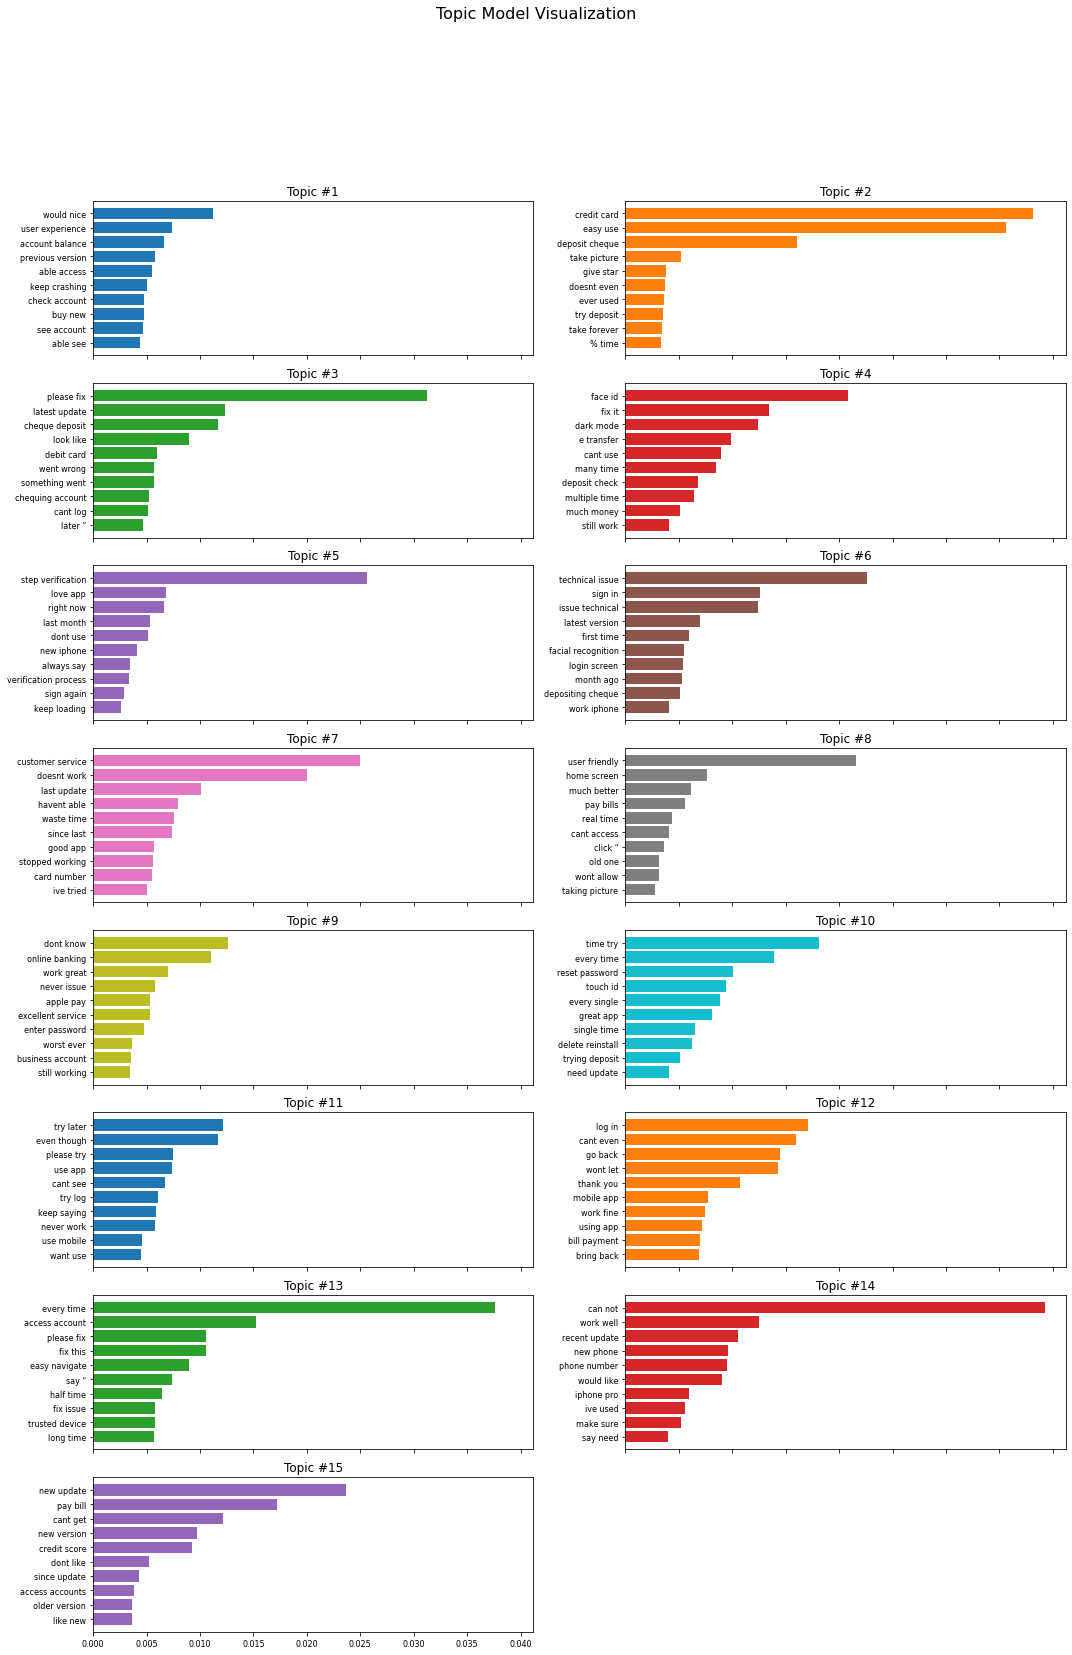

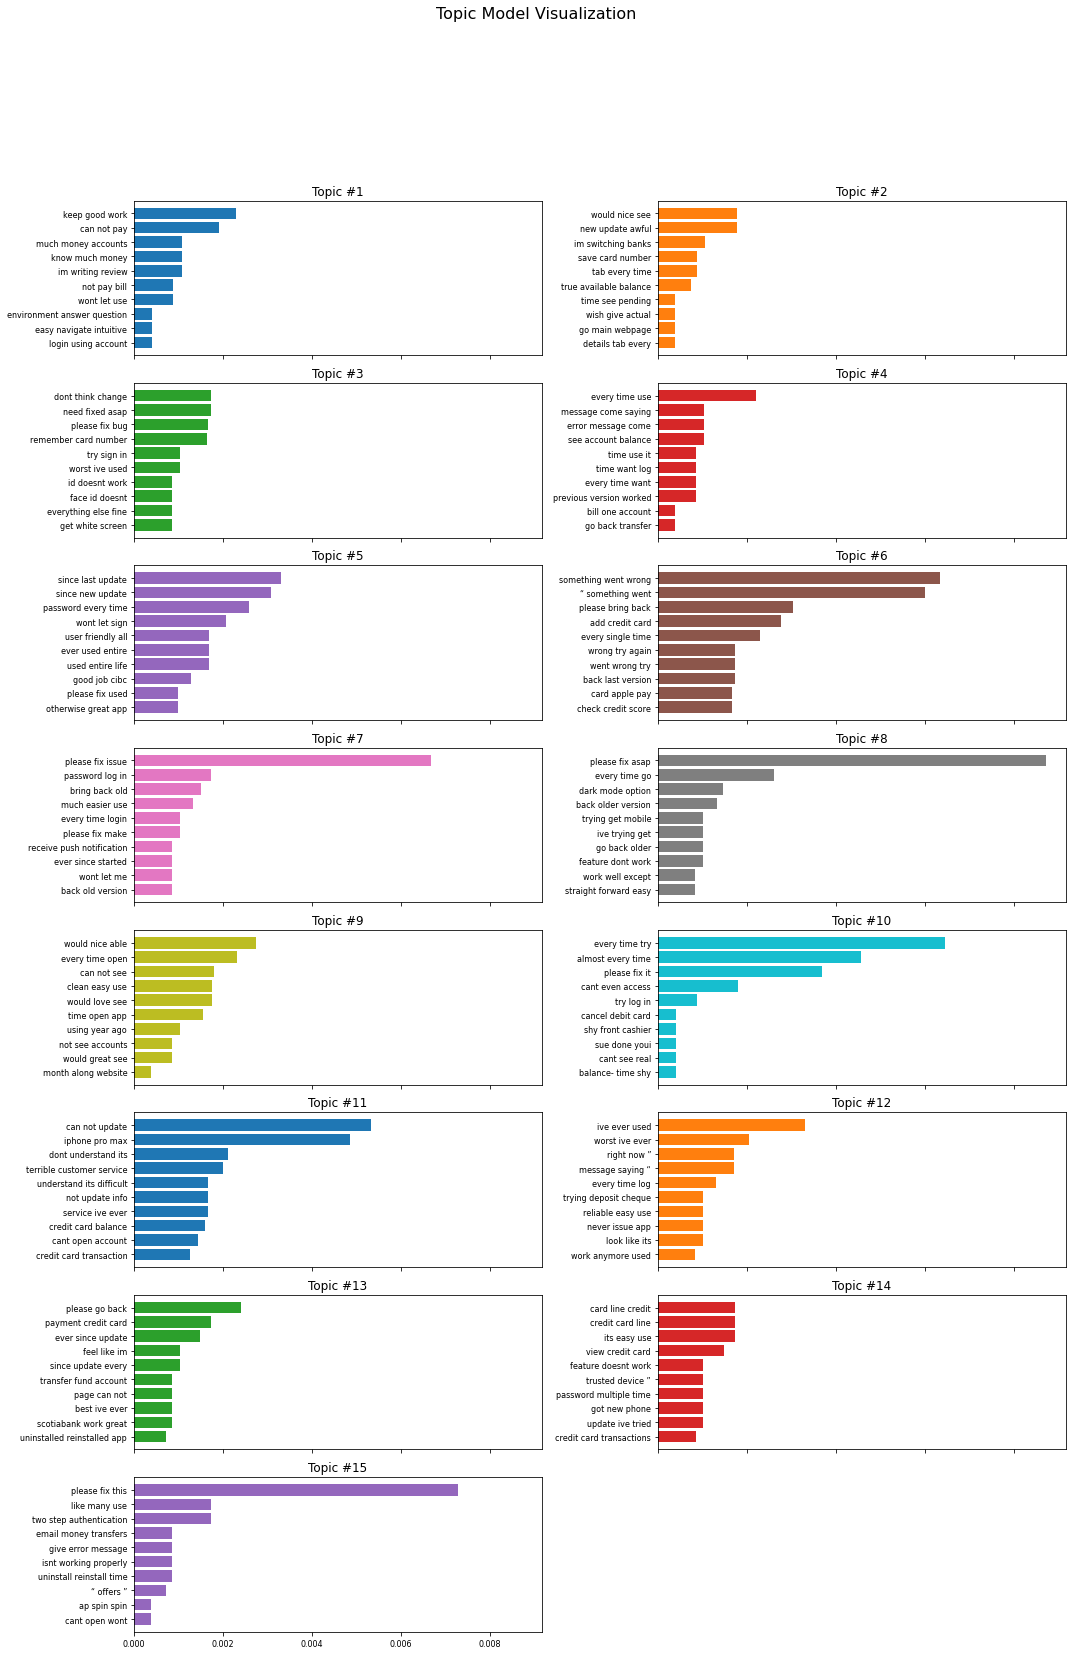

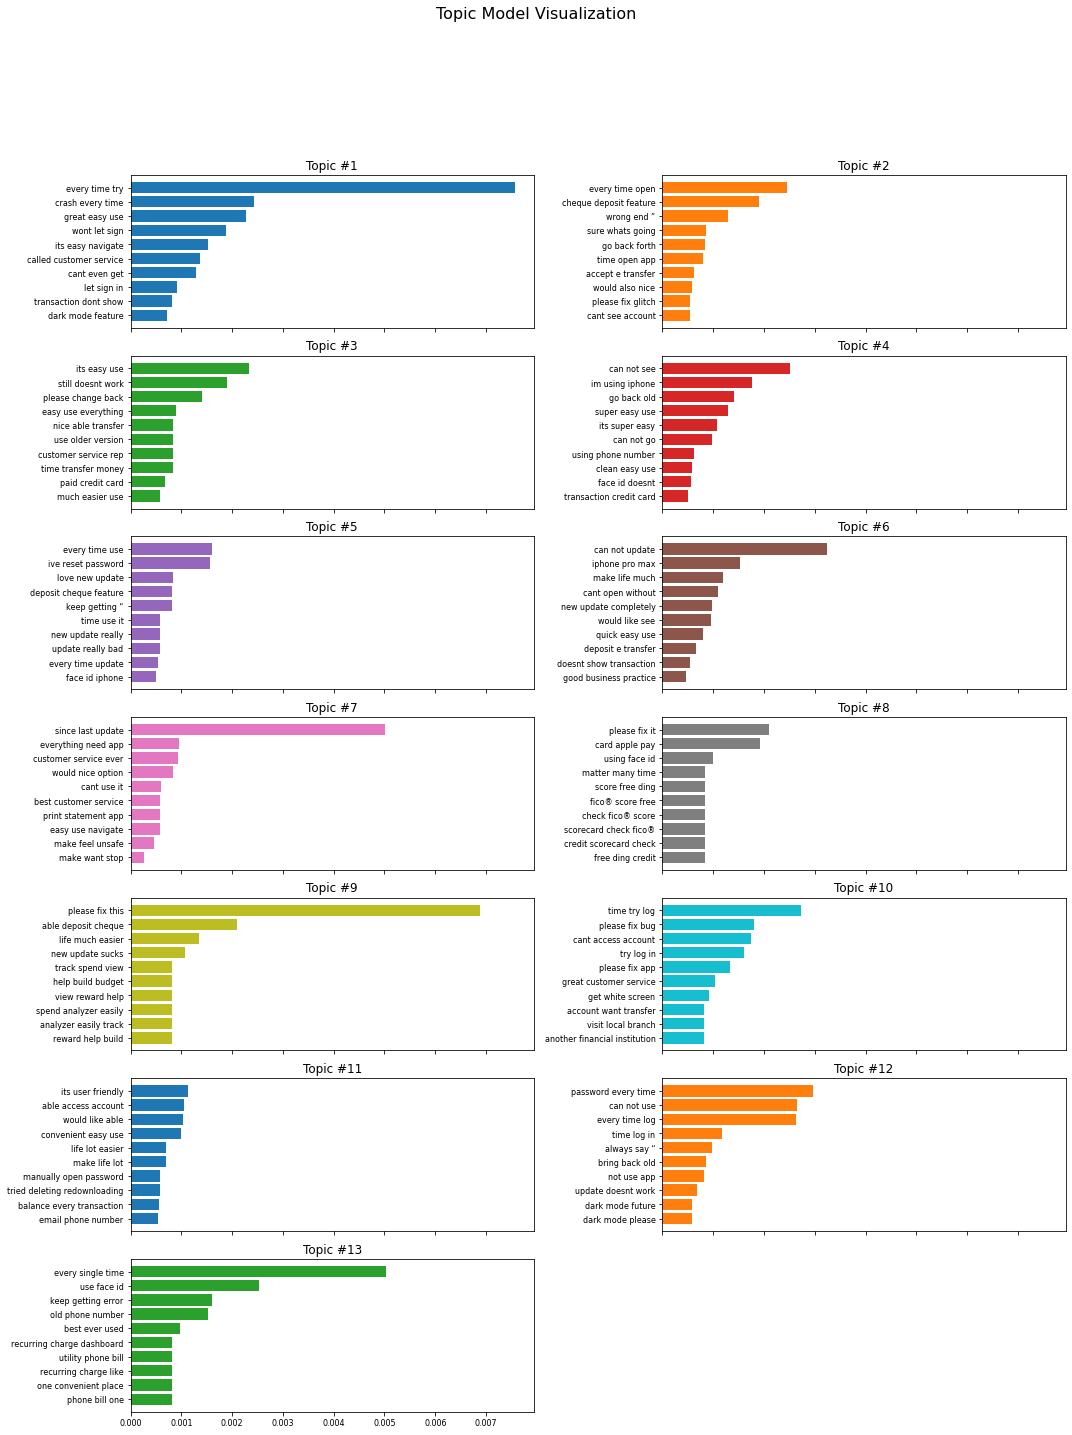

In [89]:
visualize_topics_top_words(neg_best_topic_model, 15, "ios_negative_reviews_topic_topWords.png")
visualize_topics_top_words(net_best_topic_model, 15, "ios_neutral_reviews_topic_topWords.png")
visualize_topics_top_words(pos_best_topic_model, 13, "ios_positive_reviews_topic_topWords.png")



In [90]:
# pyLDAvis.enable_notebook()

# vis = gensimvis.prepare(best_topic_model, bigram_corpus, bigram_dict)
# vis